In [1]:
# --- 1) Importi + iestatījumi ---
import os, time, pickle, random
from pathlib import Path
import numpy as np
import cv2
import face_recognition as fr
import matplotlib.pyplot as plt

# resursu mērīšanai (CPU/RAM)
try:
    import psutil
    PROC = psutil.Process(os.getpid())
except Exception:
    psutil = None
    PROC = None

# ==== pielāgo šeit ====
BASE = Path(r"C:\Users\dplau\Desktop\bakalaura_darbs\face_recognition\Dataset")   # <- nomaini
CACHE_DIR = BASE / "_cache"                # enkodingu kešatpaka
CACHE_DIR.mkdir(parents=True, exist_ok=True)

USE_CNN   = True      # False = HOG (ātrāks, vieglāks), True = CNN (precīzāks, lēnāks)
UPSAMPLE  = 0          # 0 vai 1; 1 var palīdzēt mazām sejām
RESIZE_MAX = 640       # garākās malas samazinājums pirms detekcijas (320/480/640)
USE_CACHE = True
SEED = 42
random.seed(SEED); np.random.seed(SEED)


In [2]:
# --- 2) Palīgfunkcijas ---

def list_images(folder: Path):
    exts = {".jpg", ".jpeg", ".png"}
    return sorted([p for p in folder.iterdir()
                   if p.is_file() and p.suffix.lower() in exts])

def load_and_downscale(path: Path, max_side=RESIZE_MAX):
    img = cv2.imread(str(path))  # BGR
    if img is None: return None
    h, w = img.shape[:2]
    if max(h, w) > max_side:
        scale = max_side / float(max(h, w))
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_LINEAR)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgb

def encode_one(path: Path):
    """Atgriež 128D encoding pirmajai sejai vai None."""
    if USE_CACHE:
        cf = CACHE_DIR / (path.stem + ".pkl")
        if cf.exists():
            try: return pickle.load(open(cf, "rb"))
            except Exception: pass

    rgb = load_and_downscale(path)
    if rgb is None: 
        if USE_CACHE: pickle.dump(None, open(CACHE_DIR / (path.stem + ".pkl"), "wb"))
        return None

    model = "cnn" if USE_CNN else "hog"
    boxes = fr.face_locations(rgb, number_of_times_to_upsample=UPSAMPLE, model=model)
    if not boxes:
        if USE_CACHE: pickle.dump(None, open(CACHE_DIR / (path.stem + ".pkl"), "wb"))
        return None

    enc = fr.face_encodings(rgb, known_face_locations=[boxes[0]])
    vec = np.array(enc[0], dtype=np.float32) if enc else None
    if USE_CACHE: pickle.dump(vec, open(CACHE_DIR / (path.stem + ".pkl"), "wb"))
    return vec

def l2n(v):
    n = np.linalg.norm(v) + 1e-12
    return v / n

def eer_from_dists(genuine, impostor):
    """Atgriež (tau_eer, EER) pēc distances skenēšanas (mazāks=labāk)."""
    if len(genuine)==0 or len(impostor)==0:
        return 0.6, np.nan
    cand = np.unique(np.concatenate([genuine, impostor]))
    best_tau, best_gap, best_eer = cand[0], 1.0, 1.0
    for t in cand:
        FAR = (impostor <  t).mean()
        FRR = (genuine  >= t).mean()
        gap = abs(FAR - FRR)
        if gap < best_gap:
            best_gap = gap
            best_tau = float(t)
            best_eer = float((FAR + FRR) / 2.0)
    return best_tau, best_eer

def roc_auc_from_dists(genuine, impostor, n=400):
    """ROC punktu ģenerēšana + AUC (trapeces metode)."""
    if len(genuine)==0 or len(impostor)==0:
        return np.array([0.0]), np.array([0.0]), np.nan
    lo = float(min(genuine.min(), impostor.min()))
    hi = float(max(genuine.max(), impostor.max()))
    taus = np.linspace(lo, hi, num=n)
    FPR, TPR = [], []
    for t in taus:
        FAR = (impostor < t).mean()
        TPRv = 1.0 - (genuine >= t).mean()
        FPR.append(FAR); TPR.append(TPRv)
    FPR = np.array(FPR); TPR = np.array(TPR)
    # AUC: sakārto pēc FPR pieauguma
    idx = np.argsort(FPR)
    auc = np.trapz(TPR[idx], FPR[idx])
    return FPR, TPR, float(auc)


In [3]:
# --- 3) Galerija no train/ (centroīds katrai personai) ---
persons = sorted([p.name for p in BASE.iterdir() if p.is_dir() and p.name.startswith("person")])
t0_gl = time.perf_counter()
gal_names, gal_vecs = [], []

for pname in persons:
    vecs = []
    for ip in list_images(BASE / pname / "train"):
        v = encode_one(ip)
        if v is not None: vecs.append(l2n(v))
    if vecs:
        gal_names.append(pname)
        gal_vecs.append(l2n(np.mean(np.stack(vecs, 0), 0)))

gal_names = np.array(gal_names)
gal_vecs  = np.array(gal_vecs)
t1_gl = time.perf_counter()
print(f"Galerija sagatavota: {len(gal_names)} personas. Laiks: {t1_gl - t0_gl:.2f}s")
if len(gal_vecs) == 0:
    raise SystemExit("❗ Galerija tukša — pārbaudi BASE ceļu un train/ saturu.")


Galerija sagatavota: 10 personas. Laiks: 0.49s


In [4]:
# --- 4) Sliekšņa kalibrācija (VAL): τ_EER + EER(val) ---
genuine_val, impostor_val = [], []

for pname in persons:
    for ip in list_images(BASE / pname / "val"):
        q = encode_one(ip)
        if q is None: continue
        qn = l2n(q)
        d = np.linalg.norm(gal_vecs - qn, axis=1)   # mazāks = labāk
        mask = (gal_names == pname)
        if mask.any():   genuine_val.append(d[mask].min())
        if (~mask).any(): impostor_val.append(d[~mask].min())

genuine_val  = np.array(genuine_val)
impostor_val = np.array(impostor_val)
tau_eer, eer_val = eer_from_dists(genuine_val, impostor_val)
print(f"τ_EER (val) = {tau_eer:.4f} | EER(val) ≈ {100*eer_val:.2f}%")


τ_EER (val) = 0.4467 | EER(val) ≈ 6.67%


In [5]:
# --- 5) Tests: izpilde, laiki, CPU/RAM, lēmumi ---
rows = []  # (person, file, pred, min_dist, exec_ms, fps, memMB, cpu%)

for pname in persons:
    for ip in list_images(BASE / pname / "test"):
        t0 = time.perf_counter()
        q = encode_one(ip)
        t1 = time.perf_counter()

        if q is None:
            pred, md = "No face", float("inf")
        else:
            qn = l2n(q)
            d = np.linalg.norm(gal_vecs - qn, axis=1)
            j = int(d.argmin()); md = float(d[j])
            pred = gal_names[j] if md < tau_eer else "Unknown"

        # resursi
        mem_mb = PROC.memory_info().rss / (1024*1024) if PROC else np.nan
        cpu_pc = psutil.cpu_percent(interval=None) if psutil else np.nan

        dt = (t1 - t0)
        rows.append((pname, ip.name, pred, md, dt*1000.0, 1.0/max(1e-6, dt), mem_mb, cpu_pc))


In [6]:
# --- 6) Kopsavilkums per persona un kopā ---
import collections
by_p = collections.defaultdict(list)
for r in rows: by_p[r[0]].append(r)

print("\n--- Rezultāti (pa personām) ---")
acc_all, far_all, frr_all, ms_all, fps_all, ram_all, cpu_all = [], [], [], [], [], [], []

for pname in persons:
    df = by_p.get(pname, [])
    if not df: continue
    total   = len(df)
    correct = sum(1 for *_, pred, _, _, _, _, _ in df if pred == pname)
    fa  = sum(1 for *_, pred, _, _, _, _, _ in df if (pred != pname and pred not in ["Unknown","No face"]))
    frx = sum(1 for *_, pred, _, _, _, _, _ in df if pred in ["Unknown","No face"])

    ms  = np.mean([x[4] for x in df])
    fps = np.mean([x[5] for x in df])
    ram = np.mean([x[6] for x in df if not np.isnan(x[6])]) if any(not np.isnan(x[6]) for x in df) else np.nan
    cpu = np.mean([x[7] for x in df if not np.isnan(x[7])]) if any(not np.isnan(x[7]) for x in df) else np.nan

    acc = 100*correct/total
    far = 100*fa/total
    frr = 100*frx/total

    acc_all.append(acc); far_all.append(far); frr_all.append(frr)
    ms_all.append(ms); fps_all.append(fps)
    if not np.isnan(ram): ram_all.append(ram)
    if not np.isnan(cpu): cpu_all.append(cpu)

    ram_txt = f"{ram:6.1f} MB" if not np.isnan(ram) else "n/a"
    cpu_txt = f"{cpu:5.1f}%"  if not np.isnan(cpu) else "n/a"
    print(f"{pname:>8}: ACC={acc:6.2f}% | FAR={far:6.2f}% | FRR={frr:6.2f}% | ms={ms:7.2f} | FPS={fps:6.2f} | RAM={ram_txt} | CPU={cpu_txt}")

if acc_all:
    print("\n--- Kopā ---")
    ram_mean = (np.mean(ram_all) if ram_all else float("nan"))
    cpu_mean = (np.mean(cpu_all) if cpu_all else float("nan"))
    ram_txt = f"{ram_mean:.1f} MB" if not np.isnan(ram_mean) else "n/a"
    cpu_txt = f"{cpu_mean:.1f}%"  if not np.isnan(cpu_mean) else "n/a"
    print(f"ACC={np.mean(acc_all):.2f}% | FAR={np.mean(far_all):.2f}% | FRR={np.mean(frr_all):.2f}% | "
          f"ms={np.mean(ms_all):.2f} | FPS={np.mean(fps_all):.2f} | RAM={ram_txt} | CPU={cpu_txt}")
else:
    print("❗ Nav testu datu vai nav izdevies iegūt encodingus.")



--- Rezultāti (pa personām) ---
 person1: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=   7.44 | FPS=254.60 | RAM= 248.1 MB | CPU= 11.6%
person10: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=   4.87 | FPS=361.41 | RAM= 248.1 MB | CPU= 13.2%
 person2: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=   8.00 | FPS=124.94 | RAM= 248.1 MB | CPU= 25.0%
 person3: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=   4.53 | FPS=352.21 | RAM= 248.1 MB | CPU=  7.2%
 person4: ACC= 75.00% | FAR=  0.00% | FRR= 25.00% | ms=   2.08 | FPS=605.15 | RAM= 248.1 MB | CPU=  8.3%
 person5: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=   6.20 | FPS=273.74 | RAM= 248.1 MB | CPU= 10.4%
 person6: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=   5.73 | FPS=265.51 | RAM= 248.1 MB | CPU=  8.3%
 person7: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=   4.83 | FPS=291.66 | RAM= 248.1 MB | CPU=  8.3%
 person8: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=   8.46 | FPS=220.67 | RAM= 248.1 MB | CPU= 19.4%
 person9: ACC=100.00% 


EER(test) ≈ 0.00%  |  AUC(ROC, test) = 0.9651  |  τ_EER(test) = 0.4371
EER(val)  ≈ 6.67%  |  τ_EER(val)  = 0.4467


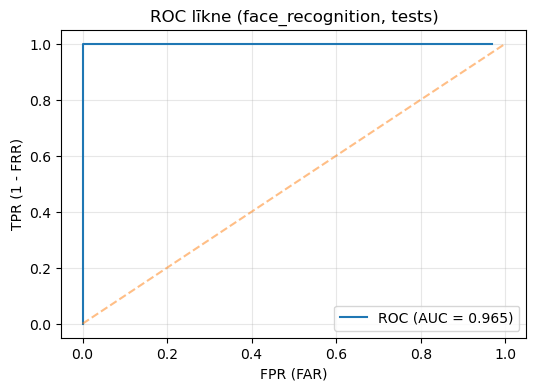

In [7]:
# --- 7) EER(test) + ROC/AUC (test) ---
# uzkonstruē genuine/impostor distances no test
genuine_t, impostor_t = [], []
for pname in persons:
    for ip in list_images(BASE / pname / "test"):
        q = encode_one(ip)
        if q is None: continue
        qn = l2n(q)
        d = np.linalg.norm(gal_vecs - qn, axis=1)
        mask = (gal_names == pname)
        if mask.any():   genuine_t.append(d[mask].min())
        if (~mask).any(): impostor_t.append(d[~mask].min())

genuine_t  = np.array(genuine_t)
impostor_t = np.array(impostor_t)

tau_eer_test, eer_test = eer_from_dists(genuine_t, impostor_t)
FPR, TPR, auc_test = roc_auc_from_dists(genuine_t, impostor_t)

print(f"\nEER(test) ≈ {100*eer_test:.2f}%  |  AUC(ROC, test) = {auc_test:.4f}  |  τ_EER(test) = {tau_eer_test:.4f}")
print(f"EER(val)  ≈ {100*eer_val:.2f}%  |  τ_EER(val)  = {tau_eer:.4f}")

# ROC grafiks (pēc izvēles saglabāt PNG)
plt.figure(figsize=(6,4))
plt.plot(FPR, TPR, label=f"ROC (AUC = {auc_test:.3f})")
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel("FPR (FAR)"); plt.ylabel("TPR (1 - FRR)")
plt.title("ROC līkne (face_recognition, tests)")
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig(BASE / "_roc_face_recognition.png", dpi=160)  # ja gribi saglabāt
plt.show()


In [8]:
# --- Papildu kļūdu pārbaude ---
print("\n--- Personas ar kļūdām ---")
errors_found = False
for pname in persons:
    df = [r for r in rows if r[0] == pname]
    if not df: 
        continue
    total = len(df)
    wrong_preds = [r for r in df if r[2] != pname]  # nepareizi klasificētie
    if wrong_preds:
        errors_found = True
        print(f"{pname}: {len(wrong_preds)}/{total} kļūdas")
        for r in wrong_preds:
            print(f"   fails: {r[1]} | prognoze: {r[2]} | dist={r[3]:.3f}")
if not errors_found:
    print("Kļūdu nav atrasts (visas personas klasificētas korekti).")



--- Personas ar kļūdām ---
person4: 1/4 kļūdas
   fails: person_4_013.jpg | prognoze: No face | dist=inf
